In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable

In [3]:
#parametri
#settare manualmente uguali a quelli usati in cluster
n_runs = 50
n_threads = [2,4,6,8]  #lista in send_steal_bilanciati.sh !
size_queue = 1024
n_body_function = 20000 #cicli in singoli job
n_elems = 2000 #job totali


In [9]:
# #$1 runs, $2 size worker_queue, $3 n_cicli in singolo job (ogni ciclo 4 operation), $4 n_job totali
!./send_steal_bilanciati.sh 50 128 100000 60

In [8]:
#carica dati da .txt
dati_Round_Random = []
dati_Round_Mostbusy = []
dati_Mostfree_Random = []
dati_Mostfree_Mostbusy = []

for i,th in enumerate(n_threads):
    dati_Round_Random.append(np.genfromtxt("test_sendRound_stealRandom_numthread"+str(th)+".txt",delimiter=',',dtype=int)[:-1])
    dati_Round_Mostbusy.append(np.genfromtxt("test_sendRound_stealMostbusy_numthread"+str(th)+".txt",delimiter=',',dtype=int)[:-1])
    dati_Mostfree_Random.append(np.genfromtxt("test_sendMostfree_stealRandom_numthread"+str(th)+".txt",delimiter=',',dtype=int)[:-1])
    dati_Mostfree_Mostbusy.append(np.genfromtxt("test_sendMostfree_stealMostbusy_numthread"+str(th)+".txt",delimiter=',',dtype=int)[:-1])

In [7]:
def multi_plot(data1, data2, data3, data4, title, labels, n_threads):
    fig, ax = plt.subplots(figsize=[10, 10])

    boxes = []
    colors = []
    group_positions = []  # Per le etichette centrate

    color_map = ["peachpuff", "orange", "yellow", "blue"]

    for i in range(len(n_threads)):
        boxes.extend([data1[i], data2[i], data3[i], data4[i]])
        colors.extend(color_map)
        # Ogni gruppo di 4 box parte alla posizione 4*i+1 → il centro è +1.5
        group_center = 4 * i + 2.5
        group_positions.append(group_center)

    # Crea boxplot
    bplot = ax.boxplot(boxes, showfliers=False, patch_artist=True)

    # Colori per ogni box
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Etichette centrate per ogni gruppo
    ax.set_xticks(group_positions)
    ax.set_xticklabels([str(n) for n in n_threads])

    # Etichette e titolo
    ax.set_ylabel('Microseconds')
    ax.set_xlabel('n_threads')
    ax.set_title(title, loc='left')
    ax.set_yscale('log')

    # Legenda (usiamo solo il primo gruppo per i colori)
    legend_handles = [bplot["boxes"][i] for i in range(4)]
    ax.legend(legend_handles, labels, loc='upper right')

    # Mediane in rosso
    for median in bplot['medians']:
        median.set_color('red')

    plt.figtext(0.54, 0.98, f"threadpool: size_queue({size_queue})\nsetup: number total job {n_elems}, n_unitary_operation_in_single_job {n_body_function*4}\nruns: {n_runs}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))

    plt.tight_layout()
    plt.show()

    # ======= Calcolo e stampa delle mediane numeriche =======
    print(f"\n=== Median values for {title} ===")
    medians = [np.median(b) for b in boxes]
    
    for i, n in enumerate(n_threads):
        print(f"\nThreads = {n}")
        for j, label in enumerate(labels):
            idx = i * 4 + j
            print(f"  {label:>12}: {medians[idx]:.2f}")

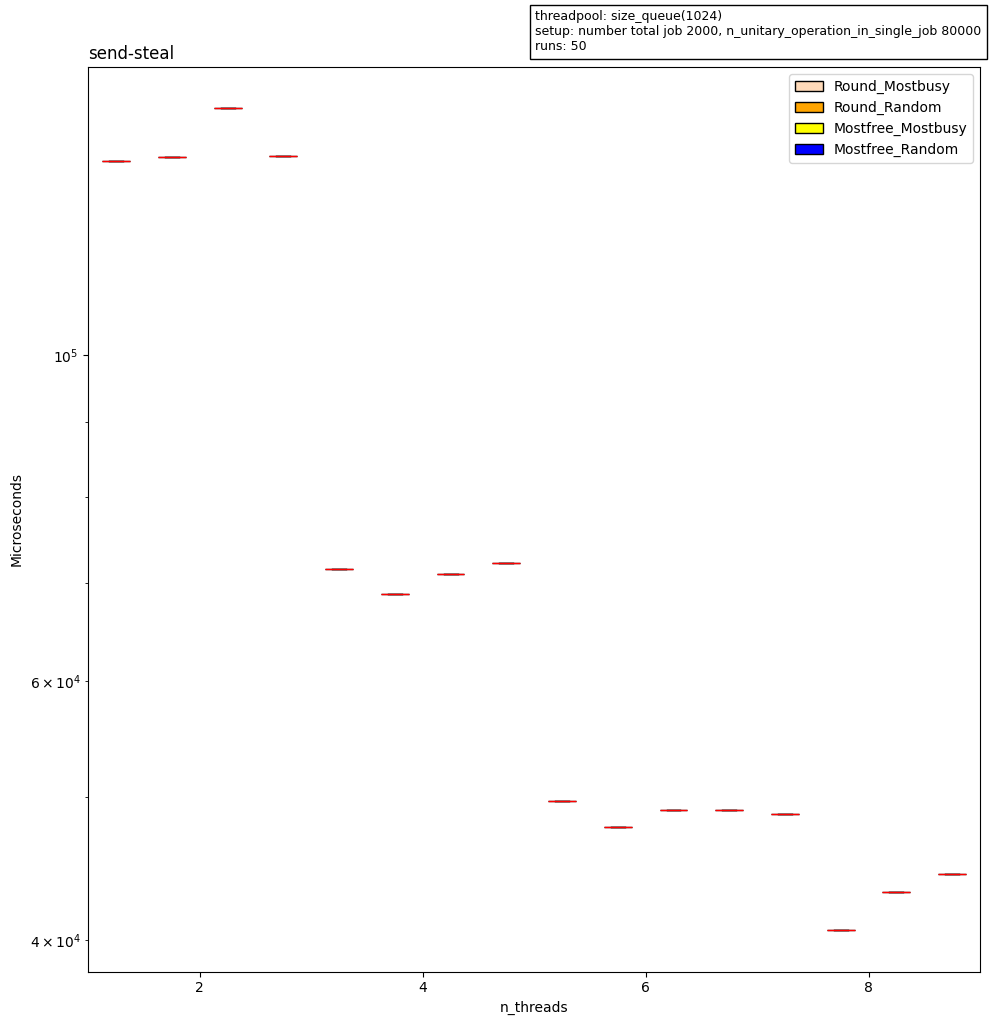


=== Median values for send-steal ===

Threads = 2
  Round_Mostbusy: 135449.00
  Round_Random: 136228.00
  Mostfree_Mostbusy: 147072.00
  Mostfree_Random: 136444.00

Threads = 4
  Round_Mostbusy: 71509.00
  Round_Random: 68715.00
  Mostfree_Mostbusy: 70919.00
  Mostfree_Random: 72205.00

Threads = 6
  Round_Mostbusy: 49703.00
  Round_Random: 47733.00
  Mostfree_Mostbusy: 49015.00
  Mostfree_Random: 49020.00

Threads = 8
  Round_Mostbusy: 48715.00
  Round_Random: 40597.00
  Mostfree_Mostbusy: 43101.00
  Mostfree_Random: 44366.00


In [9]:
label = ["Round_Mostbusy","Round_Random","Mostfree_Mostbusy","Mostfree_Random"]
multi_plot(dati_Round_Mostbusy,dati_Round_Random,dati_Mostfree_Mostbusy,dati_Mostfree_Random,"send-steal",label,n_threads)

## speedup di singolo

## NON LO METTIAMO IN REPORT, SPEEDUP POI DI MATRIX SUM. QUI CI INTERESSA SOLO CONFRONTO TRA SEND_STEAL TYPE

In [25]:
#carica dati di test fatto con singolo thread per confronto 
dati_singolo_thread = []

dati_singolo_thread.append(np.genfromtxt("test_job_single_thread.txt",delimiter=',',dtype=int)[:-1])


In [26]:
def plot_speedup(data_list,title,n_threads): #primo data in data_list è for normale e poi si compara con quello
    fig, ax = plt.subplots(figsize=[16, 8])

    data_mean = [np.mean(datum) for datum in data_list]
    speedup = np.zeros(len(n_threads))


    for i in range(len(n_threads)):
        speedup[i] = data_mean[0]/data_mean[i+1]
        

    #print(data_list)
    #print(data_mean)
    ax.plot(n_threads,speedup,'o--')

    xx = np.array(n_threads)
    ax.plot(xx,xx,'o--')
    ax.legend(['speedup','maximum'])
    ax.set_title(title, loc= 'left')
    ax.set_xticks(n_threads)

    ax.set(xlabel = 'n_threads',ylabel = 'speedup')
    plt.figtext(0.62, 0.9, f"threadpool: size_queue({size_queue})\nsetup: number total job {n_elems}, n_unitary_operation_in_single_job {n_body_function*4}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))


In [27]:
#scegli di chi plottare speedup
dati_scelti = dati_Round_Mostbusy

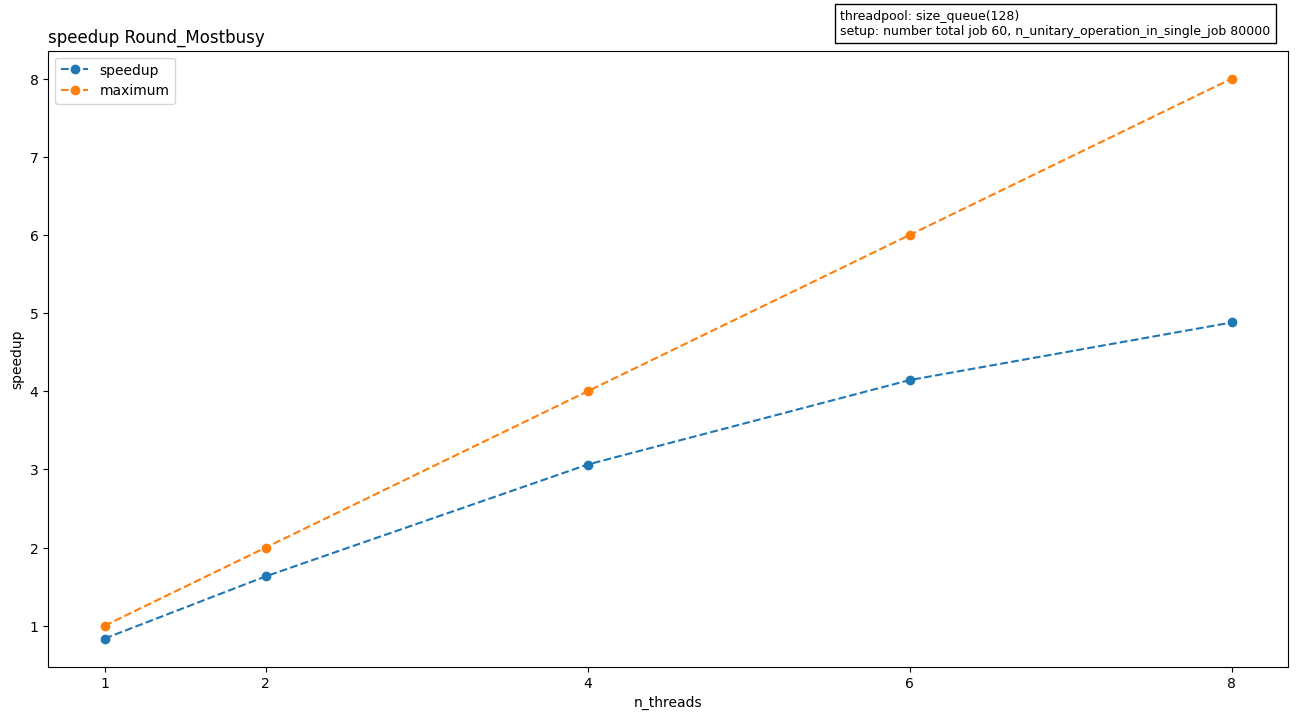

In [28]:
data_list = []
data_list.append(dati_singolo_thread)
for i in range(len(n_threads)):
    data_list.append(dati_scelti[i])
plot_speedup(data_list,"speedup Round_Mostbusy",n_threads)

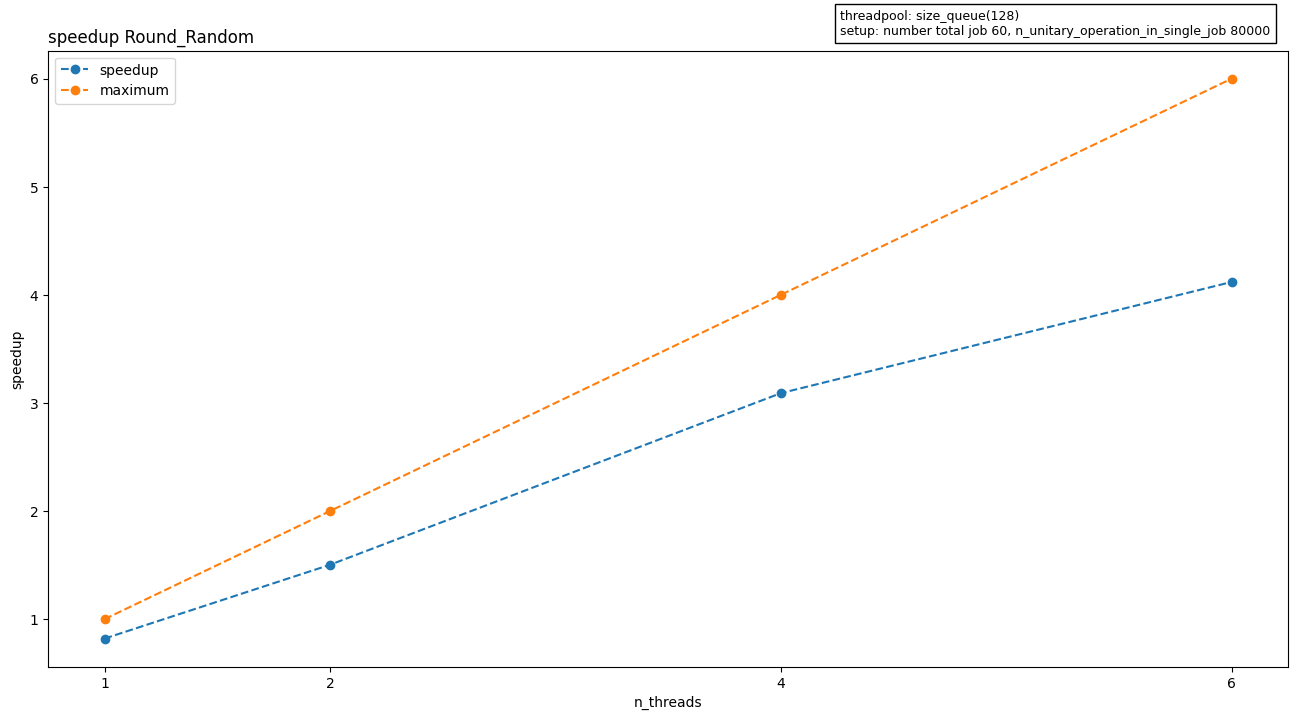

In [41]:
#scegli di chi plottare speedup
dati_scelti = dati_Round_Random
data_list = []
data_list.append(dati_singolo_thread)
for i in range(len(n_threads)):
    data_list.append(dati_scelti[i])
plot_speedup(data_list,"speedup Round_Random",n_threads)

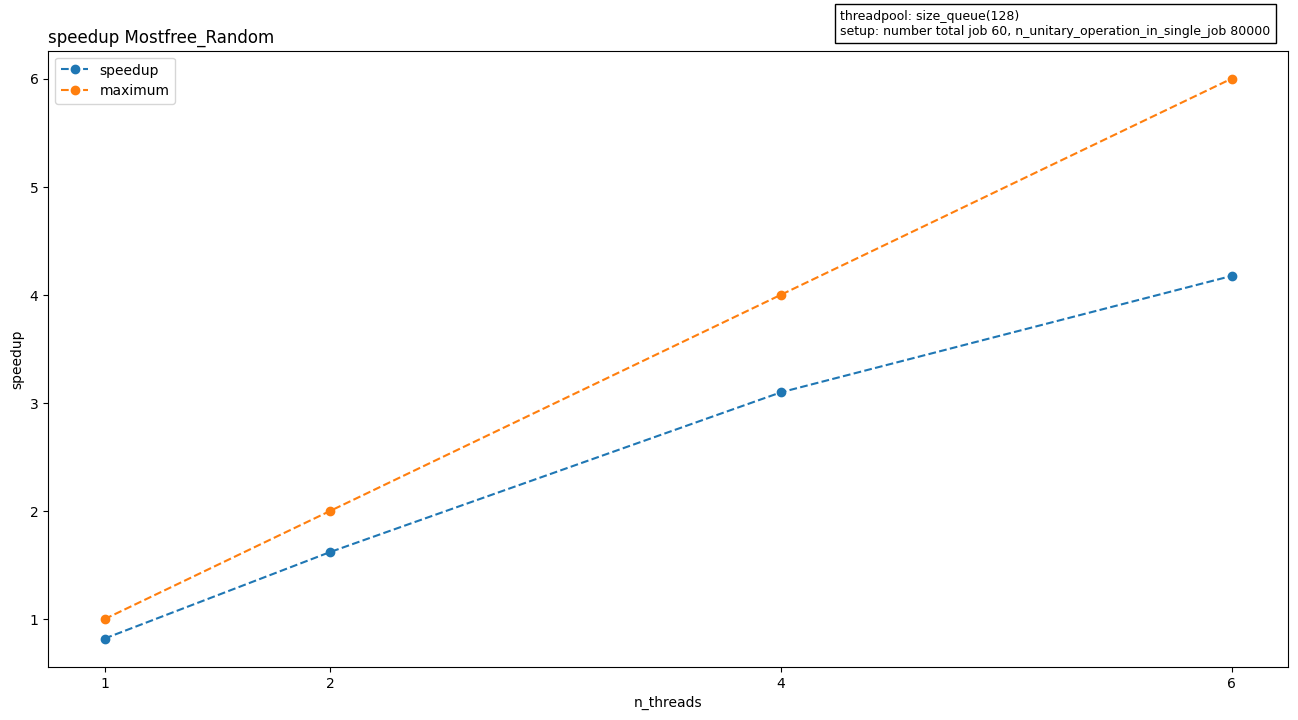

In [42]:
#scegli di chi plottare speedup
dati_scelti = dati_Mostfree_Random
data_list = []
data_list.append(dati_singolo_thread)
for i in range(len(n_threads)):
    data_list.append(dati_scelti[i])
plot_speedup(data_list,"speedup Mostfree_Random",n_threads)

In [31]:
np.min(dati_scelti[2])

np.int64(4184)